In [2]:
!pip install -q torch
#%%capture
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = 'ignore'
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp311-cp311-linux_x86_64.whl size=547369 sha256=674b8043b3fa38e32bb202b0d68a9ddd2c68b670e5e5507800a3a37b1d477ccc
  Stored in directory: /root/.cache/pip/wheels/b8/d4/0e/a80af2465354ea7355a2c153b11af2da739cfcf08b6c0b28e2
Successfully built torch-scatter
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp311-cp311-linux_x86_64.whl size=1127935 sha256=442bd1bc1296241fd5a9eff9b6c7e7ed2b81a6ed1c4f2d03b0cb5f4ca4acb72c
  Stored in directory: /root/.cache/pip/wheels/75/e2/1e/299c596063839303657c211f587f05591891cc6cf126d94d21
Successfully built to

In [3]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
data = dataset[0]
print(data)

Processing...
Done!


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [4]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F


class GCN(torch.nn.Module):
  def __init__(self, hidden_channels):
    super().__init__()
    torch.manual_seed(1234567)
    self.conv1 = GCNConv(dataset.num_features, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = x.relu()
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.conv2(x, edge_index)
    return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualise(h, colour):
  z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
  plt.figure(figsize=(10,10))
  plt.xticks([])
  plt.yticks([])
  plt.scatter(z[:, 0], z[:, 1], s=70, c=colour, cmap="Set2")
  plt.show()

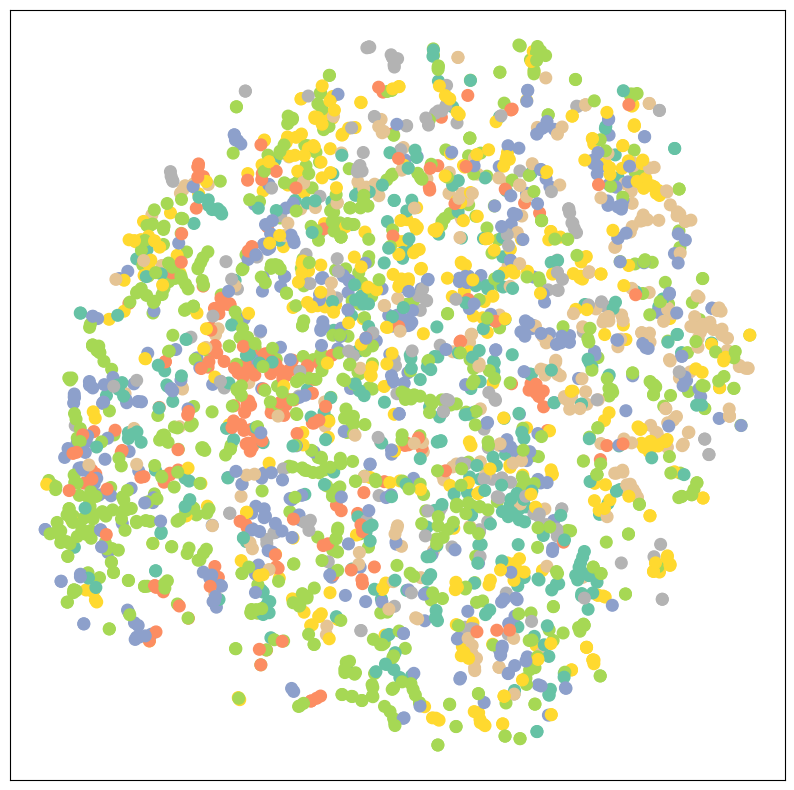

In [6]:
model.eval()

out = model(data.x, data.edge_index)
visualise(out, colour=data.y)

In [10]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
	model.train()
	optimizer.zero_grad()
	out = model(data.x, data.edge_index)
	loss = criterion(out[data.train_mask], data.y[data.train_mask])
	loss.backward()
	optimizer.step()
	return loss

def test():
	model.eval()
	out = model(data.x, data.edge_index)
	pred = out.argmax(dim=1)
	test_correct = pred[data.test_mask] == data.y[data.test_mask]
	test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
	return test_acc


for epoch in range(1, 101):
	loss = train()
	print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')


Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9409
Epoch: 003, Loss: 1.9343
Epoch: 004, Loss: 1.9275
Epoch: 005, Loss: 1.9181
Epoch: 006, Loss: 1.9086
Epoch: 007, Loss: 1.9015
Epoch: 008, Loss: 1.8933
Epoch: 009, Loss: 1.8808
Epoch: 010, Loss: 1.8685
Epoch: 011, Loss: 1.8598
Epoch: 012, Loss: 1.8482
Epoch: 013, Loss: 1.8290
Epoch: 014, Loss: 1.8233
Epoch: 015, Loss: 1.8057
Epoch: 016, Loss: 1.7966
Epoch: 017, Loss: 1.7825
Epoch: 018, Loss: 1.7617
Epoch: 019, Loss: 1.7491
Epoch: 020, Loss: 1.7310
Epoch: 021, Loss: 1.7147
Epoch: 022, Loss: 1.7056
Epoch: 023, Loss: 1.6954
Epoch: 024, Loss: 1.6697
Epoch: 025, Loss: 1.6538
Epoch: 026, Loss: 1.6312
Epoch: 027, Loss: 1.6161
Epoch: 028, Loss: 1.5899
Epoch: 029, Loss: 1.5711
Epoch: 030, Loss: 1.5576
Epoch: 031, Loss: 1.5393
Epoch: 032, Loss: 1.5137
Epoch: 033, Loss: 1.4948
Epoch: 034, Loss: 1.4913
Epoch: 035, Loss: 1.4698
Epoch: 036, Loss: 1.3998
Epoch: 037, Loss: 1.4041
Epoch: 038, Loss: 1.3761
Epoch: 039, Loss: 1.3631
Epoch: 040, Loss: 1.3258


Test Accuracy: 0.8150


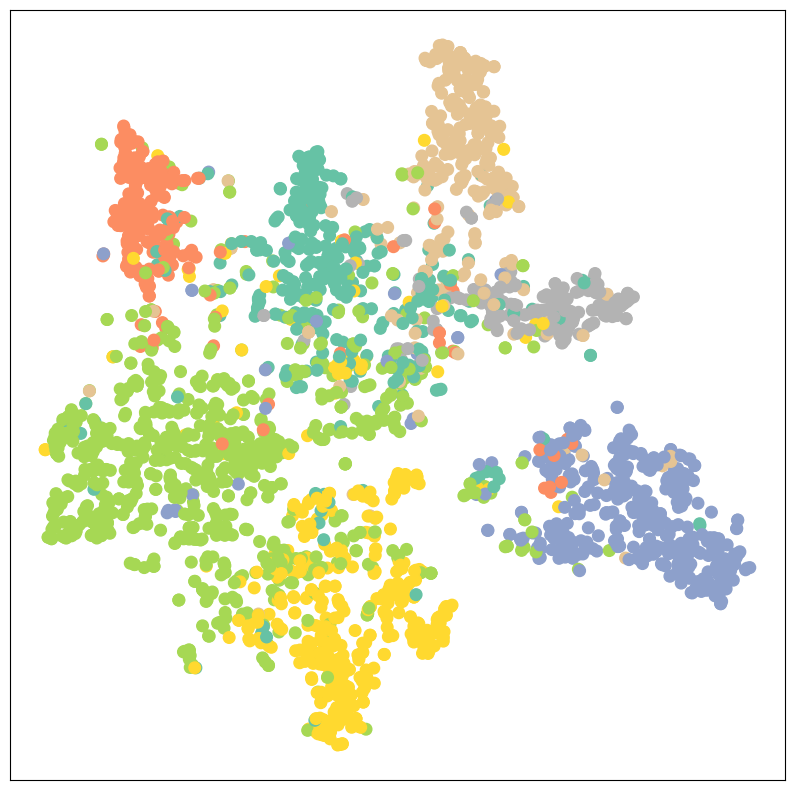

In [11]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

model.eval()
out = model(data.x, data.edge_index)
visualise(out, colour=data.y)

In [12]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
	def __init__(self, hidden_channels, heads):
		super().__init__()
		torch.manual_seed(1234567)
		self.conv1 = GATConv(dataset.num_features, hidden_channels, heads)
		self.conv2 = GATConv(heads*hidden_channels, dataset.num_classes, heads)

	def forward(self, x, edge_index):
		x = F.dropout(x, p=0.6, training=self.training)
		x = self.conv1(x, edge_index)
		x = F.elu(x)
		x = F.dropout(x, p=0.6, training=self.training)
		x = self.conv2(x, edge_index)
		return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
	model.train()
	optimizer.zero_grad()
	out = model(data.x, data.edge_index)
	loss = criterion(out[data.train_mask], data.y[data.train_mask])
	loss.backward()
	optimizer.step()
	return loss

def test(mask):
	model.eval()
	out = model(data.x, data.edge_index)
	pred = out.argmax(dim=1)
	correct = pred[mask] == data.y[mask]
	acc = int(correct.sum()) / int(mask.sum())
	return acc

val_acc_all = []
test_acc_all = []

for epoch in range(1, 101):
	loss = train()
	val_acc = test(data.val_mask)
	test_acc = test(data.test_mask)
	val_acc_all.append(val_acc)
	test_acc_all.append(test_acc)
	print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=8)
)
Epoch: 001, Loss: 4.0245, Val: 0.3520, Test: 0.3770
Epoch: 002, Loss: 3.9926, Val: 0.4760, Test: 0.5240
Epoch: 003, Loss: 3.9555, Val: 0.5000, Test: 0.5560
Epoch: 004, Loss: 3.9104, Val: 0.5440, Test: 0.5740
Epoch: 005, Loss: 3.8645, Val: 0.5500, Test: 0.5870
Epoch: 006, Loss: 3.8111, Val: 0.5560, Test: 0.5800
Epoch: 007, Loss: 3.7478, Val: 0.5460, Test: 0.5730
Epoch: 008, Loss: 3.6821, Val: 0.5320, Test: 0.5650
Epoch: 009, Loss: 3.6151, Val: 0.5280, Test: 0.5610
Epoch: 010, Loss: 3.5253, Val: 0.5220, Test: 0.5570
Epoch: 011, Loss: 3.4305, Val: 0.5080, Test: 0.5490
Epoch: 012, Loss: 3.3468, Val: 0.5040, Test: 0.5430
Epoch: 013, Loss: 3.2313, Val: 0.4900, Test: 0.5280
Epoch: 014, Loss: 3.1400, Val: 0.4800, Test: 0.5180
Epoch: 015, Loss: 3.0162, Val: 0.4700, Test: 0.5080
Epoch: 016, Loss: 2.9145, Val: 0.4620, Test: 0.4990
Epoch: 017, Loss: 2.7860, Val: 0.4520, Test: 0.4940
Epoch: 018, Loss: 2.6948, Val: 0.4340

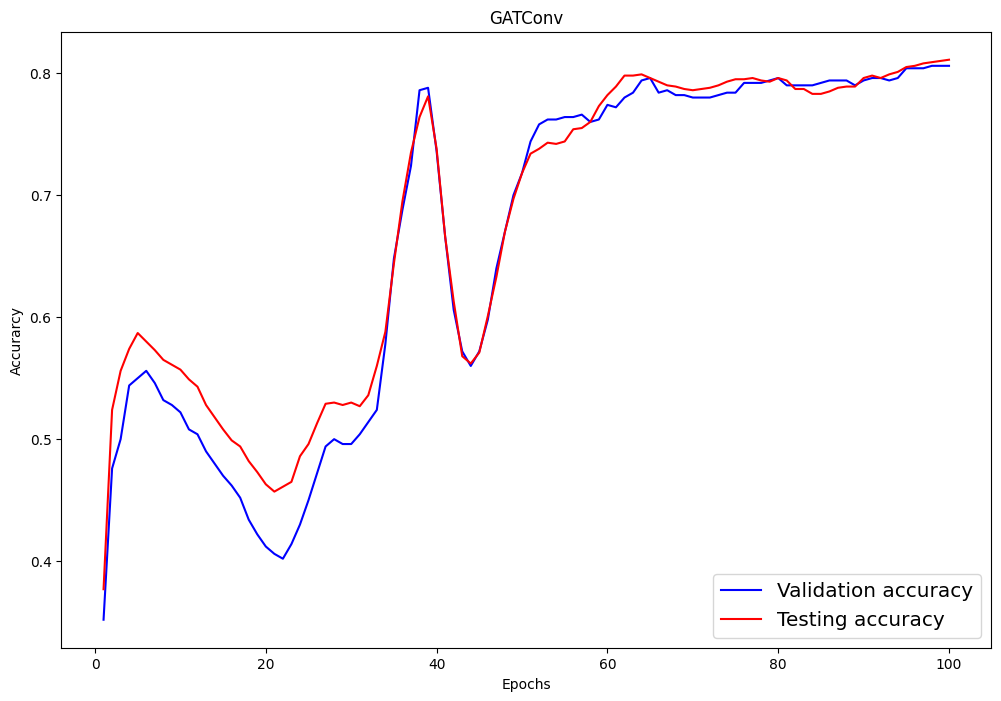

In [13]:
import numpy as np

plt.figure(figsize=(12,8))
plt.plot(np.arange(1, len(val_acc_all) + 1), val_acc_all, label='Validation accuracy', c='blue')
plt.plot(np.arange(1, len(test_acc_all) + 1), test_acc_all, label='Testing accuracy', c='red')
plt.xlabel('Epochs')
plt.ylabel('Accurarcy')
plt.title('GATConv')
plt.legend(loc='lower right', fontsize='x-large')
plt.savefig('gat_loss.png')
plt.show()

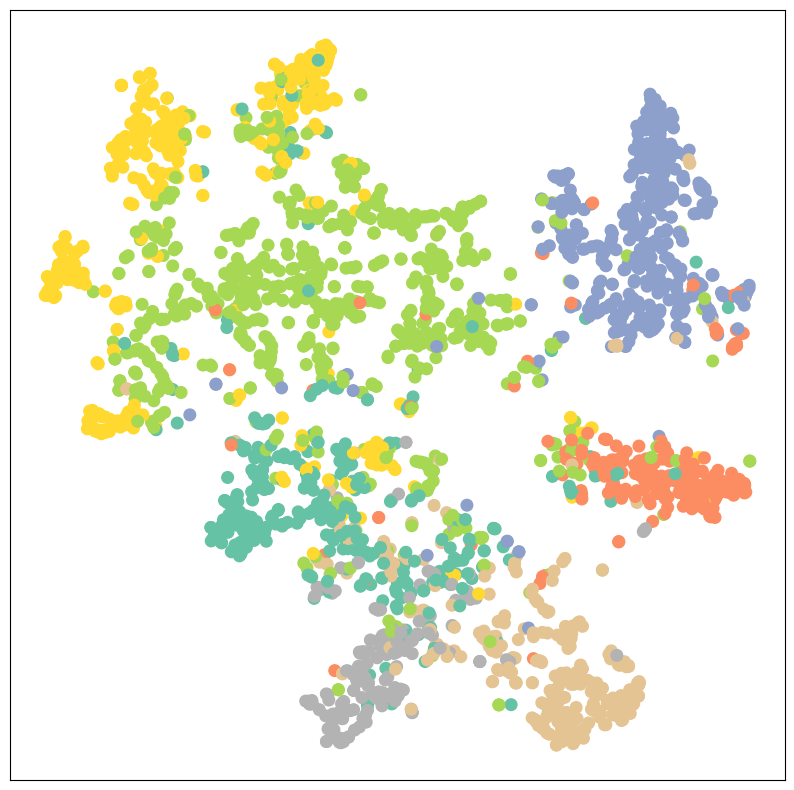

In [14]:
model.eval()

out = model(data.x, data.edge_index)
visualise(out, colour=data.y)